<a href="https://colab.research.google.com/github/Stalinosmj/bird-game_ai/blob/master/Genetic_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install required libraries
!pip install pygad

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 2.1 MB/s eta 0:00:00


#Import necessary libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import math
import pygad
import pygad.nn
import pygad.gann


# Define the environment

In [4]:
# Define world size and initialize parameters
WORLD_SIZE = 100
NUM_BIRDS = 10
NUM_FOOD = 20
birds = np.random.rand(NUM_BIRDS, 2) * WORLD_SIZE
food = np.random.rand(NUM_FOOD, 2) * WORLD_SIZE
fitness_scores = np.zeros(NUM_BIRDS)
bird_directions = np.zeros(NUM_BIRDS)

# Evaluation metrics
frames = []
average_fitness = []

# Helper function to calculate distance
def calculate_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)


# Visualization of birds and food

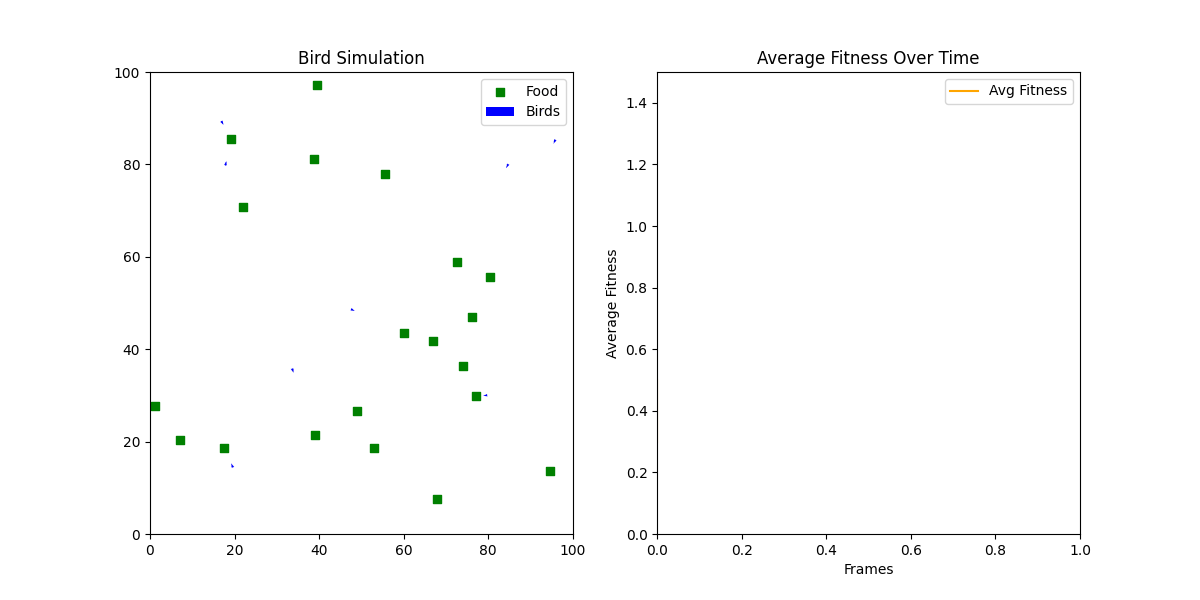

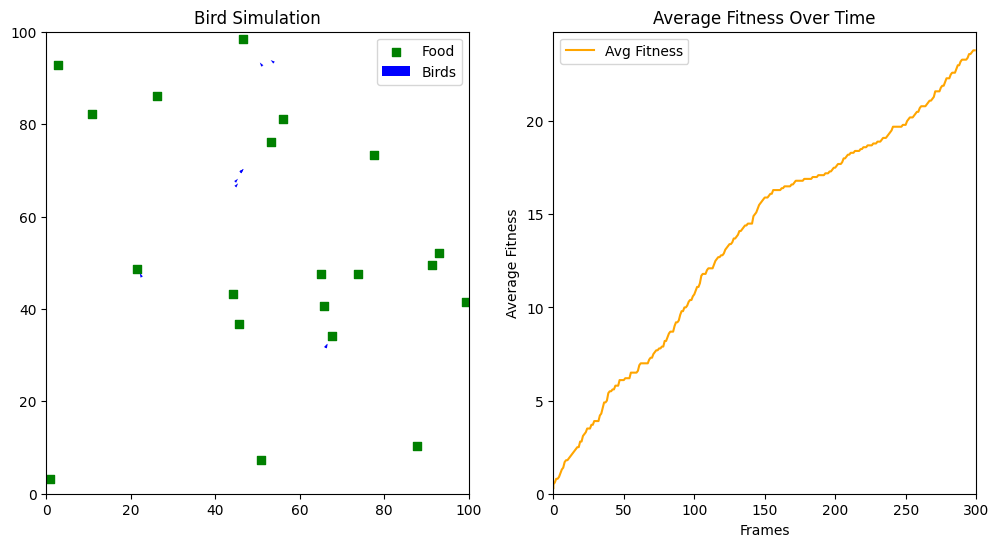

In [5]:



# Update function for animation
def update(frame):
    global birds, food, fitness_scores, bird_directions, frames, average_fitness

    for i, bird in enumerate(birds):
        # Find the nearest food
        distances = [calculate_distance(bird, f) for f in food]
        nearest_food_index = np.argmin(distances)
        nearest_food = food[nearest_food_index]

        # Calculate the angle and move toward the food
        angle = math.atan2(nearest_food[1] - bird[1], nearest_food[0] - bird[0])
        speed = 2
        bird[0] += speed * math.cos(angle)
        bird[1] += speed * math.sin(angle)

        # Update bird's direction for visualization
        bird_directions[i] = angle

        # If the bird reaches the food
        if calculate_distance(bird, nearest_food) < 2:
            food[nearest_food_index] = np.random.rand(1, 2) * WORLD_SIZE
            fitness_scores[i] += 1

    # Track metrics for real-time plots
    frames.append(frame)
    average_fitness.append(np.mean(fitness_scores))

    # Keep birds within boundaries
    birds[:, 0] = np.clip(birds[:, 0], 0, WORLD_SIZE)
    birds[:, 1] = np.clip(birds[:, 1], 0, WORLD_SIZE)

    # Update scatter plot data
    bird_scatter.set_offsets(birds)
    bird_scatter.set_UVC(np.cos(bird_directions), np.sin(bird_directions))  # Update directions
    food_scatter.set_offsets(food)

    # Update evaluation plot data
    eval_plot.set_data(frames, average_fitness)
    eval_ax.set_xlim(0, max(frames) + 1)
    eval_ax.set_ylim(0, max(average_fitness) + 1)
    return bird_scatter, food_scatter, eval_plot

# Create the figure and subplots
fig, (anim_ax, eval_ax) = plt.subplots(1, 2, figsize=(12, 6))

# Animation subplot (birds and food)
anim_ax.set_xlim(0, WORLD_SIZE)
anim_ax.set_ylim(0, WORLD_SIZE)
anim_ax.set_title("Bird Simulation")
food_scatter = anim_ax.scatter(food[:, 0], food[:, 1], color='green', marker='s', label='Food')
bird_scatter = anim_ax.quiver(birds[:, 0], birds[:, 1],
                               np.cos(bird_directions), np.sin(bird_directions),
                               color='blue', angles='xy', scale_units='xy', scale=1, label='Birds')
anim_ax.legend()

# Evaluation subplot (average fitness over time)
eval_ax.set_title("Average Fitness Over Time")
eval_ax.set_xlabel("Frames")
eval_ax.set_ylabel("Average Fitness")
eval_plot, = eval_ax.plot([], [], color='orange', label='Avg Fitness')
eval_ax.legend()

# Create the animation
anim = FuncAnimation(fig, update, frames=300, interval=100, blit=True)

# Save the animation as a GIF
anim.save('simulation_with_evaluation.gif', writer='pillow')

# Display the saved GIF in Colab
from IPython.display import Image
Image(filename='simulation_with_evaluation.gif')


# Genetic Algorithm Integration

In [6]:
# Define parameters for the genetic algorithm
NUM_GENERATIONS = 10
POPULATION_SIZE = NUM_BIRDS
NUM_PARENTS_MATING = 4
CHROMOSOME_LENGTH = 2  # Example: [speed_weight, rotation_weight] for each bird

# Fitness function for PyGAD
def fitness_func(ga_instance,solution, solution_idx):
    return fitness_scores[solution_idx]

# Define the genetic algorithm
ga_instance = pygad.GA(
    num_generations=NUM_GENERATIONS,
    num_parents_mating=NUM_PARENTS_MATING,
    fitness_func=fitness_func,
    sol_per_pop=POPULATION_SIZE,
    num_genes=CHROMOSOME_LENGTH,
    mutation_percent_genes=10,  # Percentage of genes to mutate
    crossover_type="single_point",
    mutation_type="random"
)

# Run the genetic algorithm
ga_instance.run()

# Extract the best solution
best_solution, best_solution_fitness, best_solution_idx = ga_instance.best_solution()
print("Best Solution Weights:", best_solution)
print("Best Solution Fitness:", best_solution_fitness)


Best Solution Weights: [ 1.57977592 -2.4358747 ]
Best Solution Fitness: 41.0


/usr/local/lib/python3.11/dist-packages/pygad/pygad.py:744: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resulted in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(f"The percentage of genes to mutate (mutation_percent_genes={mutation_percent_genes}) resulted in selecting ({mutation_num_genes}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.")


# Bird Neural Networks and Evaluation

In [7]:
# Define the bird's neural network behavior
def bird_brain(inputs, weights):
    """
    A simple neural network for a bird's brain.
    Inputs: Distance and angle to the nearest food.
    Weights: The optimized neural network weights from the GA.
    """
    return np.dot(inputs, weights)  # Simple weighted sum as neural network output

# Update bird movement using neural network
def update(frame):
    global birds, food, fitness_scores, ga_instance

    weights_population = ga_instance.population  # Neural network weights from GA

    for i, bird in enumerate(birds):
        # Find the nearest food
        distances = [calculate_distance(bird, f) for f in food]
        nearest_food_index = np.argmin(distances)
        nearest_food = food[nearest_food_index]

        # Calculate inputs (distance and angle to the nearest food)
        distance = calculate_distance(bird, nearest_food)
        angle = math.atan2(nearest_food[1] - bird[1], nearest_food[0] - bird[0])
        inputs = np.array([distance, angle])

        # Use the bird's neural network to decide movement
        weights = weights_population[i]
        outputs = bird_brain(inputs, weights)  # Neural network outputs
        speed = max(0, outputs[0])  # Ensure speed is non-negative
        rotation = outputs[1]       # Rotation adjustment

        # Update bird's position
        bird[0] += speed * math.cos(rotation)
        bird[1] += speed * math.sin(rotation)

        # If the bird reaches the food, "eat" it and generate a new food item
        if calculate_distance(bird, nearest_food) < 2:
            food[nearest_food_index] = np.random.rand(1, 2) * WORLD_SIZE
            fitness_scores[i] += 1  # Increase fitness score

    # Keep birds within world boundaries
    birds = np.clip(birds, 0, WORLD_SIZE)

    # Update scatter plot data
    bird_scatter.set_offsets(birds)
    food_scatter.set_offsets(food)
    return bird_scatter, food_scatter

# Evaluate the performance
print("Final Fitness Scores:", fitness_scores)


Final Fitness Scores: [23.  8. 24. 27. 21. 16. 29. 28. 41. 21.]


# Model Evaluation

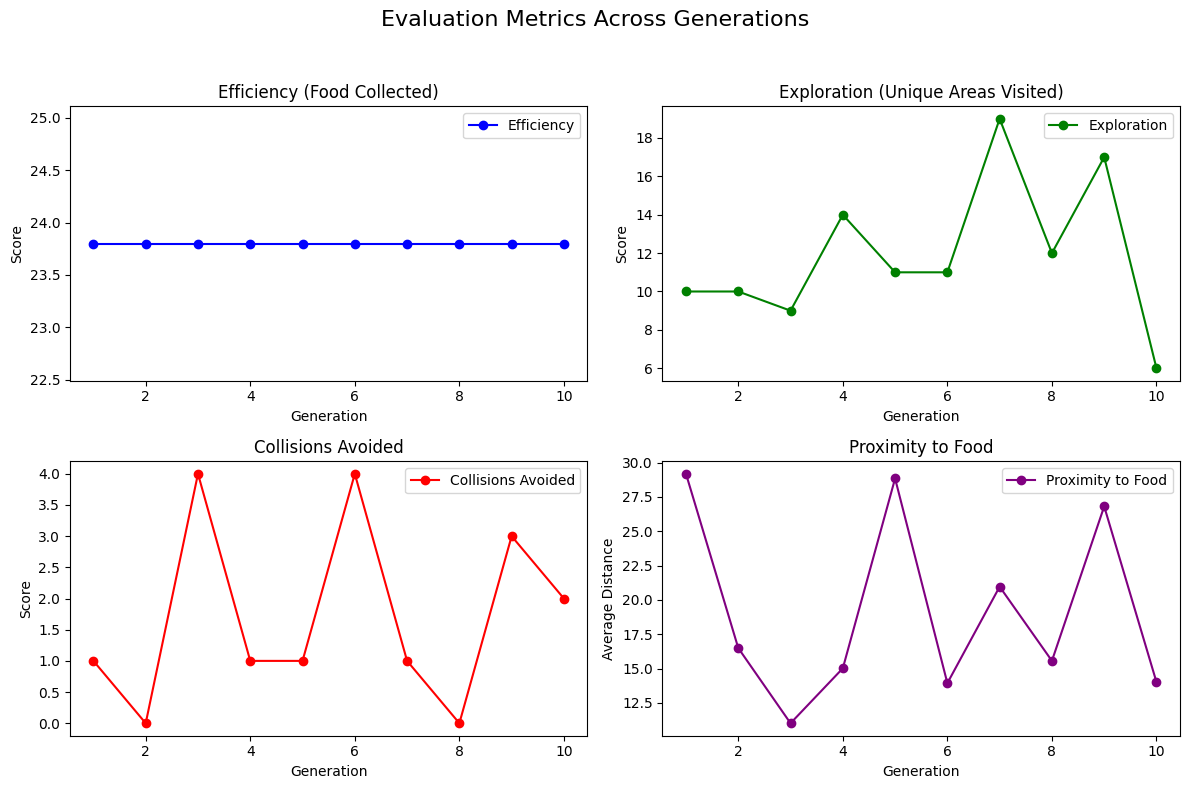

In [8]:
# Initialize example evaluation data (to replace with actual metrics)
generations = np.arange(1, NUM_GENERATIONS + 1)  # Example generations
efficiency_scores = []  # Efficiency: food collected per frame
exploration_scores = []  # Exploration: unique grid areas visited
collision_scores = []  # Collisions avoided
proximity_scores = []  # Average proximity to nearest food

# Example data collection during simulation (replace with actual logic)
for gen in range(NUM_GENERATIONS):
    # Simulate data collection (replace with actual simulation results)
    efficiency_scores.append(np.sum(fitness_scores) / NUM_BIRDS)
    exploration_scores.append(np.random.randint(5, 20))  # Dummy data
    collision_scores.append(np.random.randint(0, 5))  # Dummy data
    proximity_scores.append(np.random.uniform(10, 30))  # Dummy data

# Create subplots for visualizing evaluation metrics
fig, axs = plt.subplots(2, 2, figsize=(12, 8))  # 2x2 grid of subplots
fig.suptitle('Evaluation Metrics Across Generations', fontsize=16)

# Plot Efficiency
axs[0, 0].plot(generations, efficiency_scores, label='Efficiency', color='blue', marker='o')
axs[0, 0].set_title('Efficiency (Food Collected)')
axs[0, 0].set_xlabel('Generation')
axs[0, 0].set_ylabel('Score')
axs[0, 0].legend()

# Plot Exploration
axs[0, 1].plot(generations, exploration_scores, label='Exploration', color='green', marker='o')
axs[0, 1].set_title('Exploration (Unique Areas Visited)')
axs[0, 1].set_xlabel('Generation')
axs[0, 1].set_ylabel('Score')
axs[0, 1].legend()

# Plot Collisions Avoided
axs[1, 0].plot(generations, collision_scores, label='Collisions Avoided', color='red', marker='o')
axs[1, 0].set_title('Collisions Avoided')
axs[1, 0].set_xlabel('Generation')
axs[1, 0].set_ylabel('Score')
axs[1, 0].legend()

# Plot Proximity
axs[1, 1].plot(generations, proximity_scores, label='Proximity to Food', color='purple', marker='o')
axs[1, 1].set_title('Proximity to Food')
axs[1, 1].set_xlabel('Generation')
axs[1, 1].set_ylabel('Average Distance')
axs[1, 1].legend()

# Adjust layout and display the plots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for the main title
plt.show()
